In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
#Importing the necssary:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset, random_split

In [50]:
# Function to load the data from a given folder (remains unchanged)
def load_data(folder_path):
    X, y = [], []
    class_folders = ['a', 'ai', 'chA', 'bA', 'dA']

    for class_label, class_folder in enumerate(class_folders):
        class_path = os.path.join(folder_path, class_folder, class_folder)  # For the a/a, ai/ai structure

        # Process training data
        train_path = os.path.join(class_path, 'train')
        for file_name in os.listdir(train_path):
            file_path = os.path.join(train_path, file_name)
            X.append(torch.tensor(parse_file(file_path), dtype=torch.float32))
            y.append(class_label)  # Assign class label as 0, 1, 2, 3, or 4

        # Process test data
        dev_path = os.path.join(class_path, 'dev')
        for file_name in os.listdir(dev_path):
            file_path = os.path.join(dev_path, file_name)
            X.append(torch.tensor(parse_file(file_path), dtype=torch.float32))
            y.append(class_label)  # Same label for test data

    return X, torch.tensor(y, dtype=torch.long)


In [51]:
# Load data from the folder
X, y = load_data('/content/drive/MyDrive/Hand_writing_Data')

# Pad the sequences to ensure they all have the same length
X_padded = pad_sequence(X, batch_first=True)  # Pad sequences at the end, X_padded is (num_samples, max_seq_len, 2)

# Combine all data into a single dataset
full_dataset = TensorDataset(X_padded, y)

# Calculate sizes for train and test split
num_samples = len(full_dataset)
train_size = int(0.8 * num_samples)  # 80% for training
test_size = num_samples - train_size  # Remaining 20%

# Split the dataset into training and validation sets
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [52]:
# Check the sizes of the datasets
print("Training set size:", len(train_dataset))
print("Testing set size:", len(test_dataset))


Training set size: 356
Testing set size: 89


In [53]:
# Initialize device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
import torch
import torch.nn as nn

In [55]:
# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size  # Store hidden_size as an attribute
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Pass through fully connected layer
        out = self.fc(out[:, -1, :])
        return out


# RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size  # Store hidden_size as an attribute
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Pass through fully connected layer
        out = self.fc(out[:, -1, :])
        return out


In [56]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

In [57]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

In [58]:
# Hyperparameters
input_size = 2
num_classes = 5
num_epochs = 100
batch_size = 32

In [59]:
# Hyperparameters to tune
learning_rates = [0.001, 0.0001, 0.00001]
hidden_sizes = [64, 128, 256]
num_layers_list = [2, 5, 10]

best_rnn_model = None
best_lstm_model = None
best_rnn_accuracy = 0
best_lstm_accuracy = 0
results = []

In [60]:
# Store training loss for each configuration
def plot_losses_vs_epochs(train_losses, model_type, hyperparams):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(6, 3))
    plt.plot(epochs, train_losses, label='Train losses')
    plt.xlabel('Epochs')
    plt.ylabel('Train losses')
    plt.title(f'{model_type} losses vs Epochs - LR: {hyperparams[0]}, Hidden Size: {hyperparams[1]}, Layers: {hyperparams[2]}')
    plt.legend()
    plt.show()

In [61]:
rnn_train_losses = []
lstm_train_losses = []
rnn_test_accuracies = []
lstm_test_accuracies = []

In [62]:
# Function to train the model
def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    train_losses = []
    previous_loss = None
    tolerance = 1e-4

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        # Convergence criteria
        if previous_loss is not None and abs(previous_loss - train_loss) < tolerance:
            print(f'Convergence reached at epoch {epoch+1}')
            break
        previous_loss = train_loss

    #training accuracy:
    model.eval()
    all_preds_train, all_labels_train = [], []
    with torch.no_grad():
        for inputs_train, labels_train in train_loader:
            inputs_train, labels_train = inputs_train.to(device), labels_train.to(device)
            outputs_train = model(inputs_train)
            _, predicted_train = torch.max(outputs_train.data, 1)
            all_preds_train.extend(predicted_train.cpu().numpy())
            all_labels_train.extend(labels_train.cpu().numpy())

    # Calculate train accuracy
    train_accuracy = accuracy_score(all_labels_train, all_preds_train)
    cm_train = confusion_matrix(all_labels_train, all_preds_train)

    #printing train accuracy
    print(f'train Accuracy: {train_accuracy:.4f}')

    # After training, evaluate on test set
    model.eval()
    all_preds_test, all_labels_test = [], []
    with torch.no_grad():
        for inputs_test, labels_test in test_loader:
            inputs_test, labels = inputs_test.to(device), labels_test.to(device)
            outputs_test = model(inputs_test)
            _, predicted_test = torch.max(outputs_test.data, 1)
            all_preds_test.extend(predicted_test.cpu().numpy())
            all_labels_test.extend(labels_test.cpu().numpy())

    # Calculate test accuracy
    test_accuracy = accuracy_score(all_labels_test, all_preds_test)
    cm_test = confusion_matrix(all_labels_test, all_preds_test)

    print(f'Test Accuracy: {test_accuracy:.4f}')
    # plot_confusion_matrix(cm_test)
    print(cm_test)

    return train_accuracy, test_accuracy, train_losses

# Function to plot confusion matrix
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

Training LSTM with LR: 0.001, Hidden Size: 64, Layers: 2
Convergence reached at epoch 24
train Accuracy: 0.2022
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 1 13  0  0  0]
 [ 1 12  0  0  0]
 [ 0 23  0  0  0]]



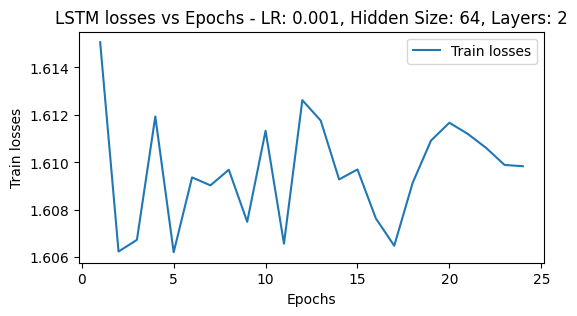

Training LSTM with LR: 0.001, Hidden Size: 64, Layers: 5
Convergence reached at epoch 11
train Accuracy: 0.2135
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]



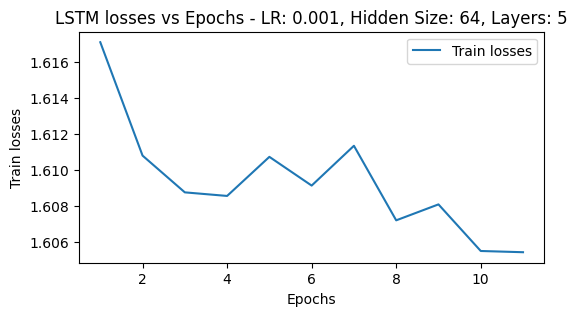

Training LSTM with LR: 0.001, Hidden Size: 64, Layers: 10
Convergence reached at epoch 8
train Accuracy: 0.2135
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]



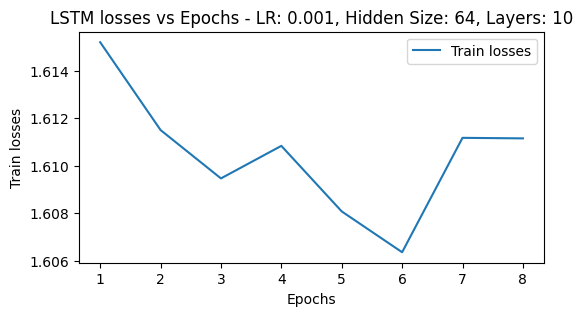

Training LSTM with LR: 0.001, Hidden Size: 128, Layers: 2
Convergence reached at epoch 3
train Accuracy: 0.2107
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]



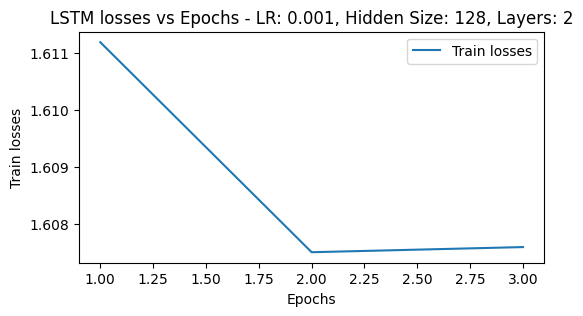

Training LSTM with LR: 0.001, Hidden Size: 128, Layers: 5
Convergence reached at epoch 12
train Accuracy: 0.2107
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]



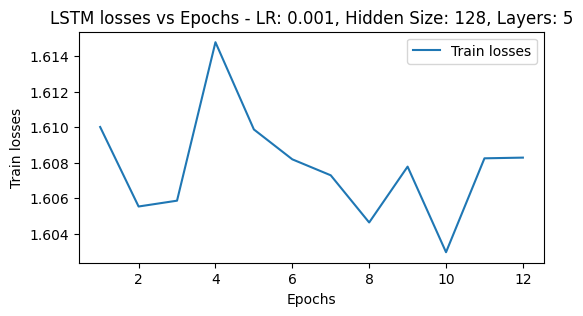

Training LSTM with LR: 0.001, Hidden Size: 128, Layers: 10
Convergence reached at epoch 58
train Accuracy: 0.2135
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]



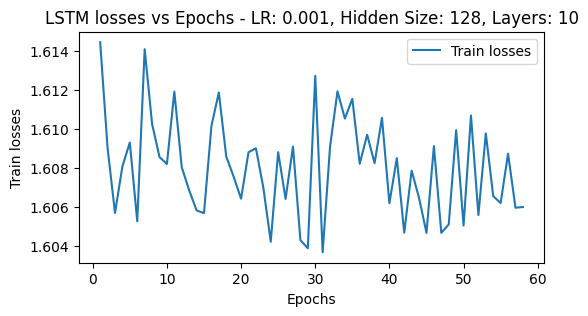

Training LSTM with LR: 0.001, Hidden Size: 256, Layers: 2
Convergence reached at epoch 106
train Accuracy: 0.2107
Test Accuracy: 0.1461
[[ 0  0  0 24  0]
 [ 0  0  0 15  0]
 [ 0  0  0 14  0]
 [ 0  0  0 13  0]
 [ 0  0  0 23  0]]



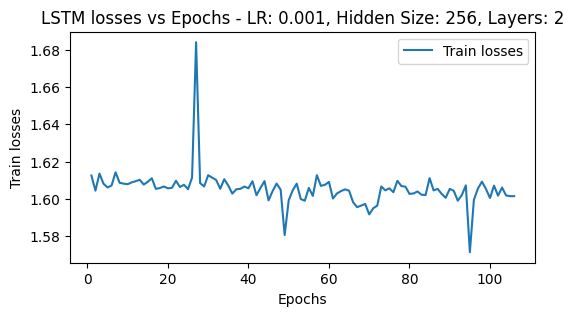

Training LSTM with LR: 0.001, Hidden Size: 256, Layers: 5
Convergence reached at epoch 40
train Accuracy: 0.2135
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]



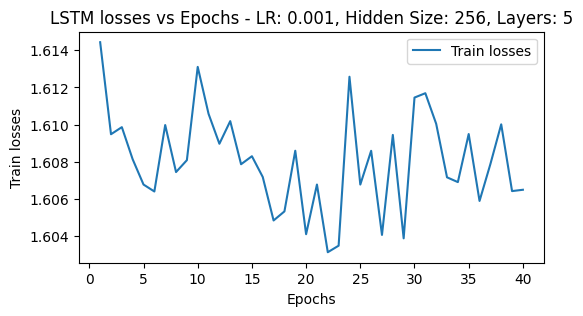

Training LSTM with LR: 0.001, Hidden Size: 256, Layers: 10
Convergence reached at epoch 52
train Accuracy: 0.2135
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]



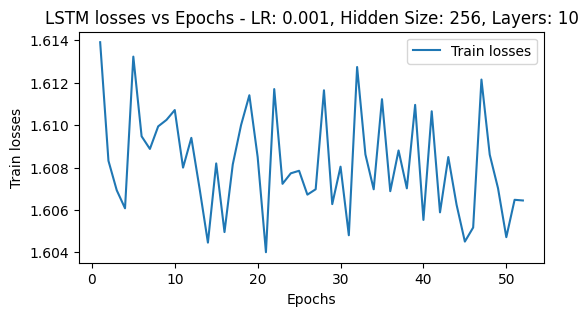

Training LSTM with LR: 0.0001, Hidden Size: 64, Layers: 2
Convergence reached at epoch 12
train Accuracy: 0.1854
Test Accuracy: 0.2584
[[ 0  0  0  0 24]
 [ 0  0  0  0 15]
 [ 0  0  0  0 14]
 [ 0  0  0  0 13]
 [ 0  0  0  0 23]]



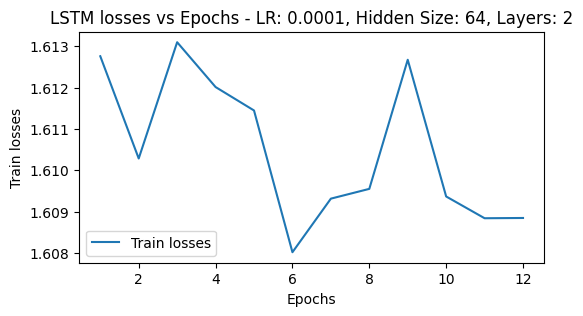

Training LSTM with LR: 0.0001, Hidden Size: 64, Layers: 5
Convergence reached at epoch 36
train Accuracy: 0.2107
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]



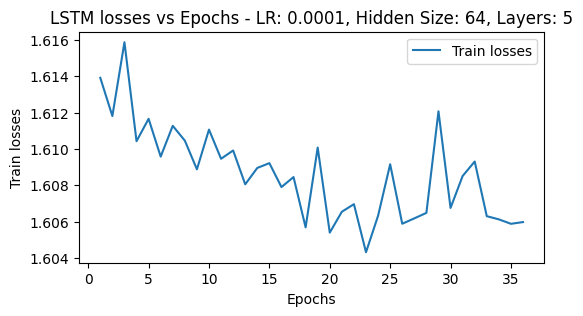

Training LSTM with LR: 0.0001, Hidden Size: 64, Layers: 10
Convergence reached at epoch 3
train Accuracy: 0.1854
Test Accuracy: 0.2584
[[ 0  0  0  0 24]
 [ 0  0  0  0 15]
 [ 0  0  0  0 14]
 [ 0  0  0  0 13]
 [ 0  0  0  0 23]]



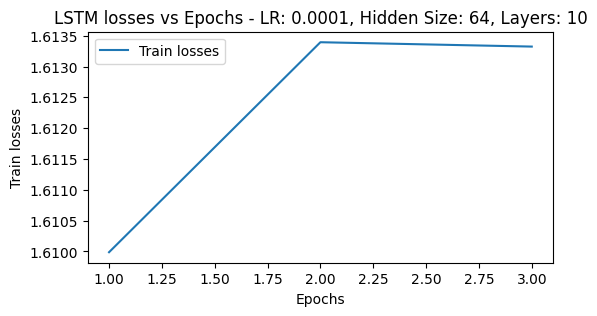

Training LSTM with LR: 0.0001, Hidden Size: 128, Layers: 2
Convergence reached at epoch 5
train Accuracy: 0.2107
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]



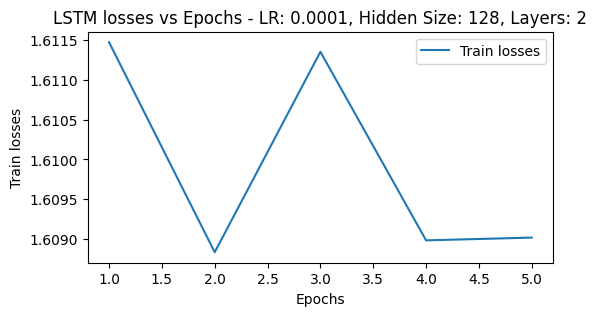

Training LSTM with LR: 0.0001, Hidden Size: 128, Layers: 5
Convergence reached at epoch 46
train Accuracy: 0.2135
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]



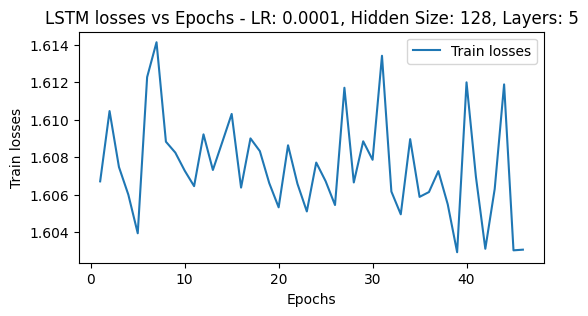

Training LSTM with LR: 0.0001, Hidden Size: 128, Layers: 10
Convergence reached at epoch 4
train Accuracy: 0.2079
Test Accuracy: 0.1461
[[ 0  0  0 24  0]
 [ 0  0  0 15  0]
 [ 0  0  0 14  0]
 [ 0  0  0 13  0]
 [ 0  0  0 23  0]]



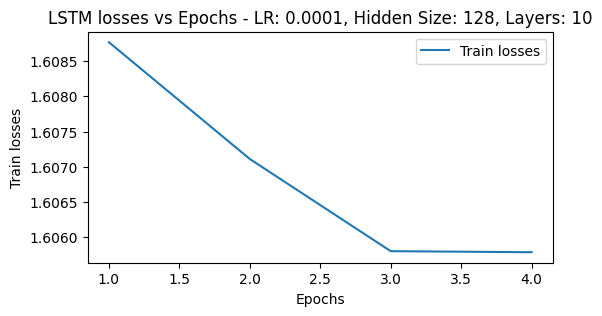

Training LSTM with LR: 0.0001, Hidden Size: 256, Layers: 2
Convergence reached at epoch 48
train Accuracy: 0.2135
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]



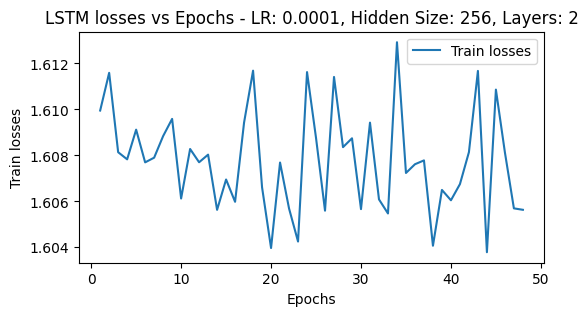

Training LSTM with LR: 0.0001, Hidden Size: 256, Layers: 5
Convergence reached at epoch 2
train Accuracy: 0.2079
Test Accuracy: 0.1461
[[ 0  0  0 24  0]
 [ 0  0  0 15  0]
 [ 0  0  0 14  0]
 [ 0  0  0 13  0]
 [ 0  0  0 23  0]]



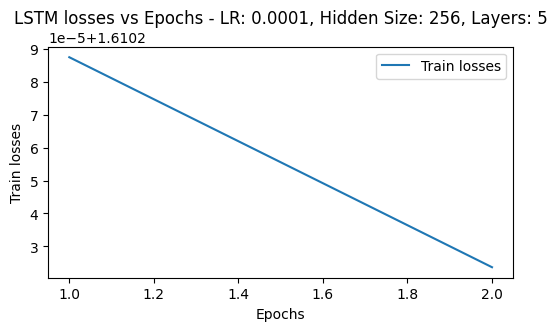

Training LSTM with LR: 0.0001, Hidden Size: 256, Layers: 10
Convergence reached at epoch 6
train Accuracy: 0.2135
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]



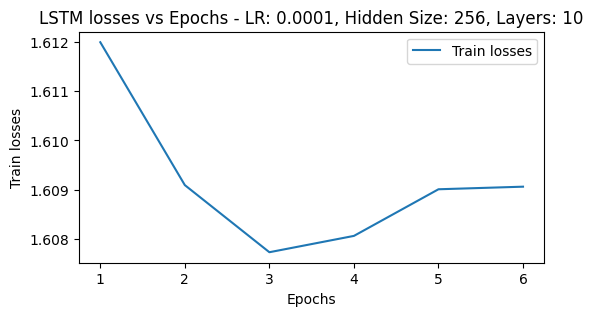

Training LSTM with LR: 1e-05, Hidden Size: 64, Layers: 2
Convergence reached at epoch 5
train Accuracy: 0.2107
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]



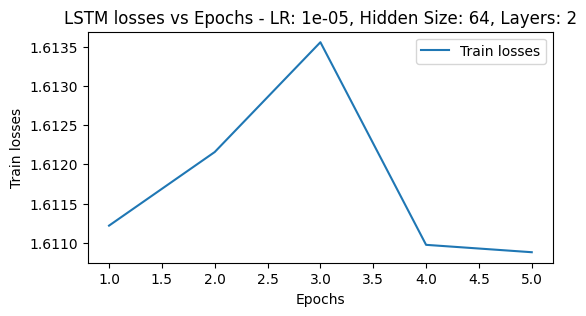

Training LSTM with LR: 1e-05, Hidden Size: 64, Layers: 5
Convergence reached at epoch 4
train Accuracy: 0.2107
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]



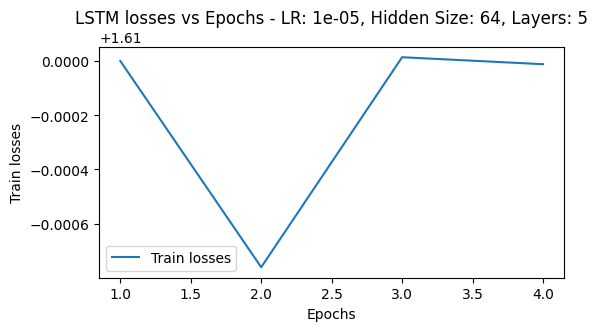

Training LSTM with LR: 1e-05, Hidden Size: 64, Layers: 10
Convergence reached at epoch 11
train Accuracy: 0.1854
Test Accuracy: 0.2584
[[ 0  0  0  0 24]
 [ 0  0  0  0 15]
 [ 0  0  0  0 14]
 [ 0  0  0  0 13]
 [ 0  0  0  0 23]]



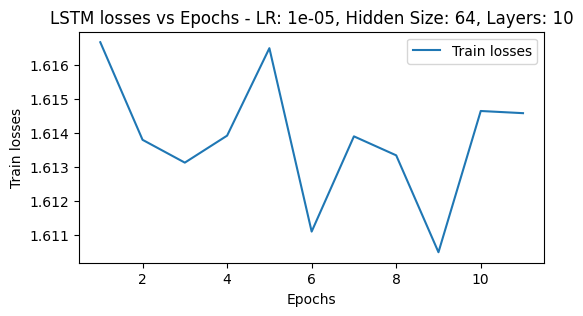

Training LSTM with LR: 1e-05, Hidden Size: 128, Layers: 2
Convergence reached at epoch 7
train Accuracy: 0.2135
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]



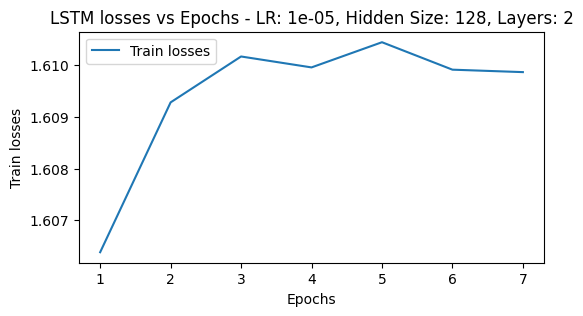

Training LSTM with LR: 1e-05, Hidden Size: 128, Layers: 5
Convergence reached at epoch 26
train Accuracy: 0.2107
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]



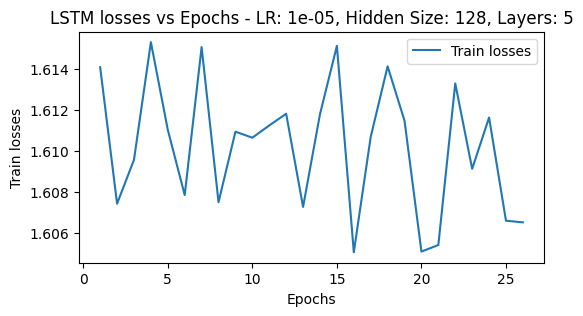

Training LSTM with LR: 1e-05, Hidden Size: 128, Layers: 10
Convergence reached at epoch 23
train Accuracy: 0.2135
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]



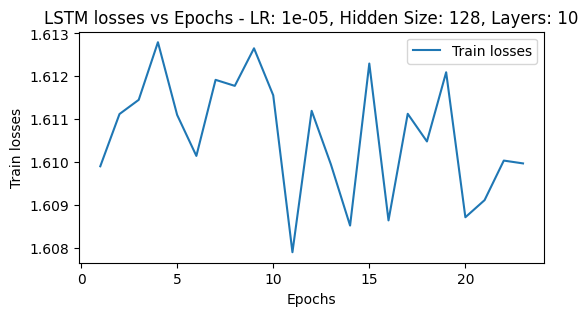

Training LSTM with LR: 1e-05, Hidden Size: 256, Layers: 2
Convergence reached at epoch 22
train Accuracy: 0.2107
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]



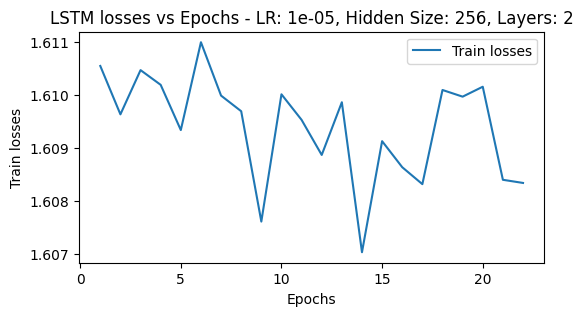

Training LSTM with LR: 1e-05, Hidden Size: 256, Layers: 5
Convergence reached at epoch 20
train Accuracy: 0.2079
Test Accuracy: 0.1461
[[ 0  0  0 24  0]
 [ 0  0  0 15  0]
 [ 0  0  0 14  0]
 [ 0  0  0 13  0]
 [ 0  0  0 23  0]]



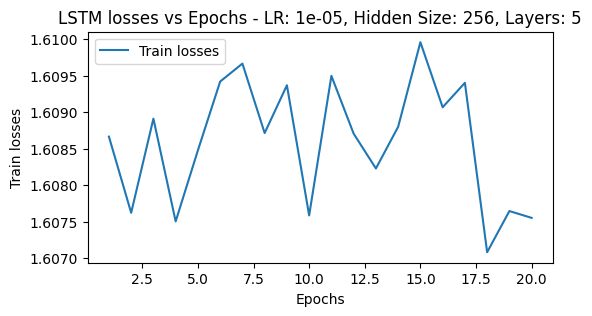

Training LSTM with LR: 1e-05, Hidden Size: 256, Layers: 10
Convergence reached at epoch 18
train Accuracy: 0.2135
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]



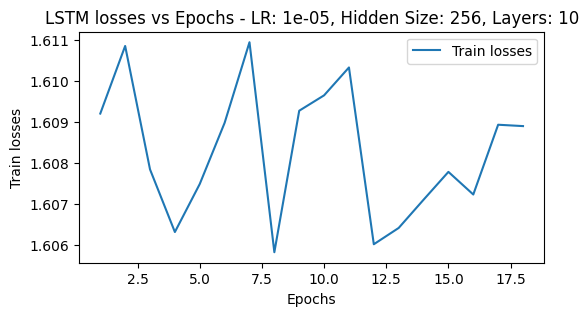

In [63]:
# Loop over all hyperparameter combinations for LSTM
for lr in learning_rates:
    for hidden_size in hidden_sizes:
        for num_layers in num_layers_list:
            print(f"Training LSTM with LR: {lr}, Hidden Size: {hidden_size}, Layers: {num_layers}")

            # LSTM Model Definition
            lstm_model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
            lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)

            #Definig the criterion:
            criterion = nn.CrossEntropyLoss()

            # Train and evaluate the LSTM model
            lstm_train_accuracy, lstm_test_accuracy, lstm_train_losses= train_and_evaluate_model(
                lstm_model, train_loader, test_loader, criterion, lstm_optimizer, num_epochs=1000, device=device
            )

            print()
            # Store results
            results.append({
                'model_type': 'LSTM',
                'lr': lr,
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'train_accuracy': lstm_train_accuracy,
                'test_accuracy': lstm_test_accuracy
            })

            # Plot train_losses vs. epochs for LSTM
            plot_losses_vs_epochs(lstm_train_losses, 'LSTM', [lr, hidden_size, num_layers])

            # Update the best LSTM model
            if lstm_test_accuracy > best_lstm_accuracy:
                best_lstm_accuracy = lstm_test_accuracy
                best_lstm_model = lstm_model

Training RNN with LR: 0.001, Hidden Size: 64, Layers: 2
Convergence reached at epoch 89
train Accuracy: 0.2135
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]


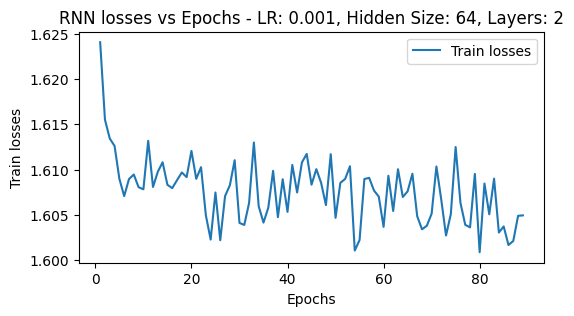

Training RNN with LR: 0.001, Hidden Size: 64, Layers: 5
Convergence reached at epoch 6
train Accuracy: 0.2135
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]


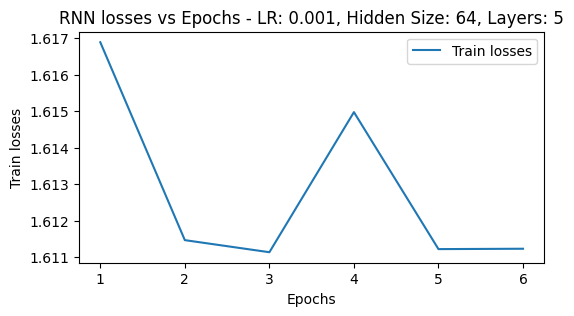

Training RNN with LR: 0.001, Hidden Size: 64, Layers: 10
Convergence reached at epoch 157
train Accuracy: 0.2135
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]


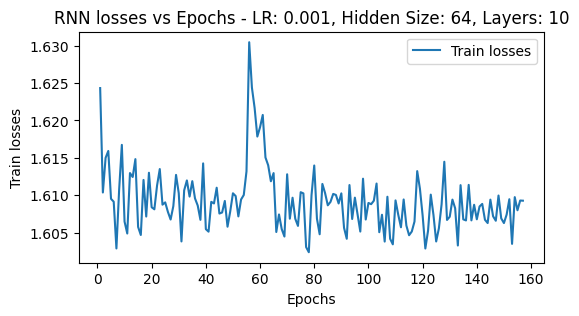

Training RNN with LR: 0.001, Hidden Size: 128, Layers: 2
Convergence reached at epoch 54
train Accuracy: 0.2163
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]


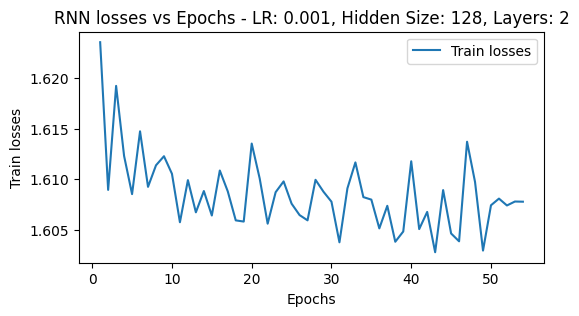

Training RNN with LR: 0.001, Hidden Size: 128, Layers: 5
Convergence reached at epoch 14
train Accuracy: 0.2107
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]


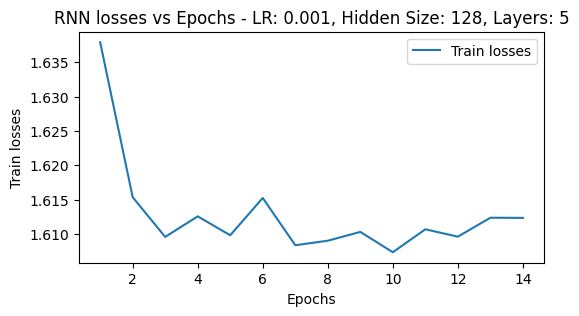

Training RNN with LR: 0.001, Hidden Size: 128, Layers: 10
Convergence reached at epoch 45
train Accuracy: 0.2135
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]


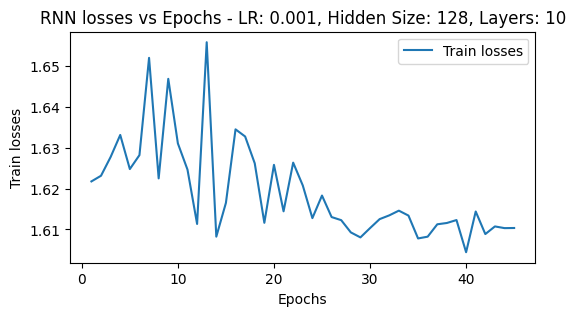

Training RNN with LR: 0.001, Hidden Size: 256, Layers: 2
Convergence reached at epoch 181
train Accuracy: 0.2107
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]


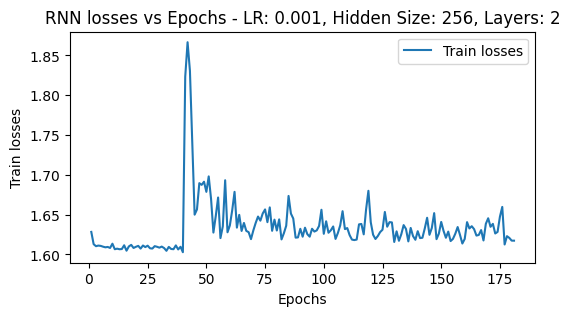

Training RNN with LR: 0.001, Hidden Size: 256, Layers: 5
Convergence reached at epoch 55
train Accuracy: 0.2079
Test Accuracy: 0.1461
[[ 0  0  0 24  0]
 [ 0  0  0 15  0]
 [ 0  0  0 14  0]
 [ 0  0  0 13  0]
 [ 0  0  0 23  0]]


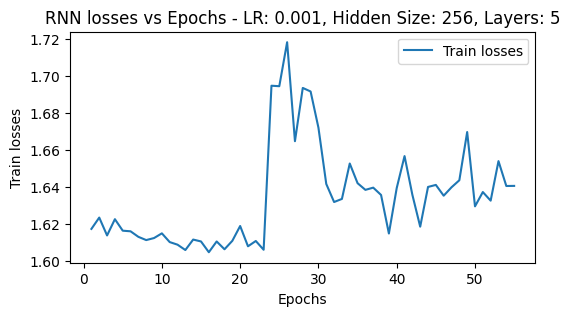

Training RNN with LR: 0.001, Hidden Size: 256, Layers: 10
Convergence reached at epoch 143
train Accuracy: 0.2079
Test Accuracy: 0.1461
[[ 0  0  0 24  0]
 [ 0  0  0 15  0]
 [ 0  0  0 14  0]
 [ 0  0  0 13  0]
 [ 0  0  0 23  0]]


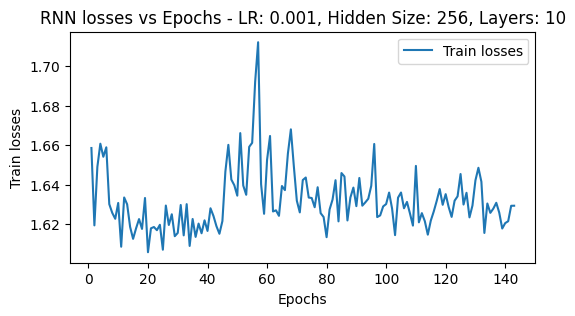

Training RNN with LR: 0.0001, Hidden Size: 64, Layers: 2
Convergence reached at epoch 184
train Accuracy: 0.2163
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]


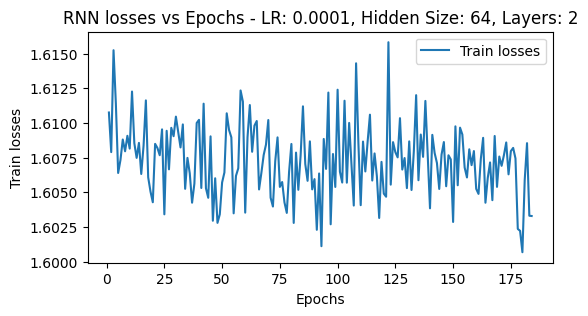

Training RNN with LR: 0.0001, Hidden Size: 64, Layers: 5
Convergence reached at epoch 96
train Accuracy: 0.2135
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]


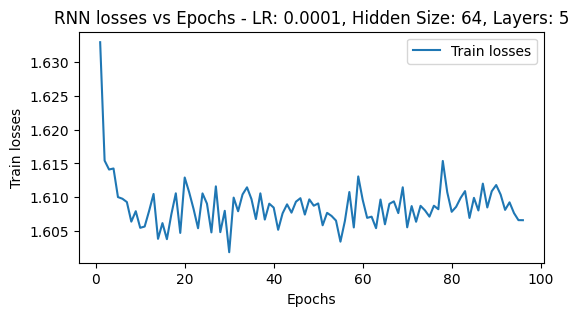

Training RNN with LR: 0.0001, Hidden Size: 64, Layers: 10
Convergence reached at epoch 171
train Accuracy: 0.2079
Test Accuracy: 0.1461
[[ 0  0  0 24  0]
 [ 0  0  0 15  0]
 [ 0  0  0 14  0]
 [ 0  0  0 13  0]
 [ 0  0  0 23  0]]


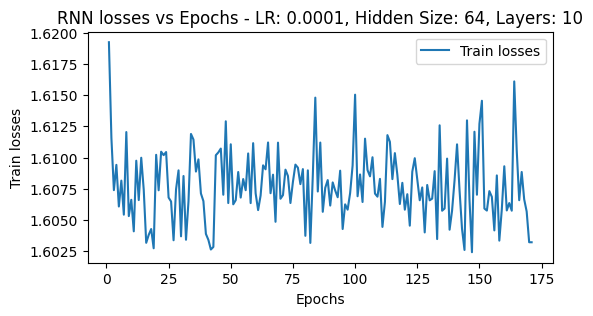

Training RNN with LR: 0.0001, Hidden Size: 128, Layers: 2
Convergence reached at epoch 38
train Accuracy: 0.2107
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]


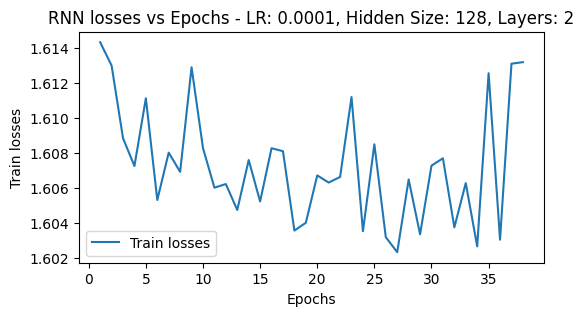

Training RNN with LR: 0.0001, Hidden Size: 128, Layers: 5
Convergence reached at epoch 19
train Accuracy: 0.2135
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]


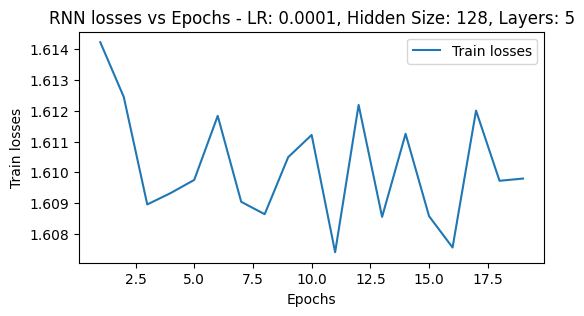

Training RNN with LR: 0.0001, Hidden Size: 128, Layers: 10
Convergence reached at epoch 125
train Accuracy: 0.2107
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]


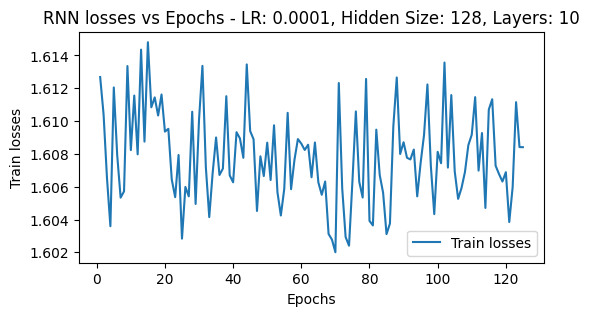

Training RNN with LR: 0.0001, Hidden Size: 256, Layers: 2
Convergence reached at epoch 66
train Accuracy: 0.2135
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]


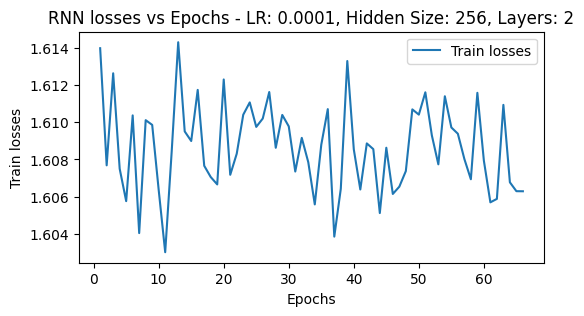

Training RNN with LR: 0.0001, Hidden Size: 256, Layers: 5
Convergence reached at epoch 203
train Accuracy: 0.2135
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]


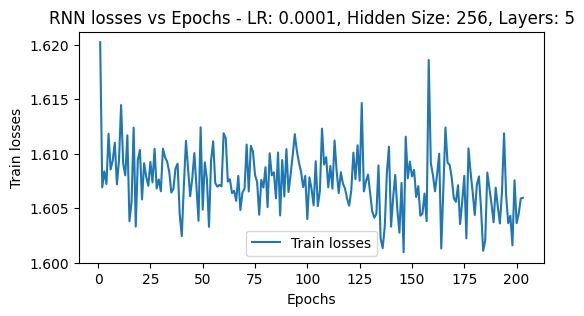

Training RNN with LR: 0.0001, Hidden Size: 256, Layers: 10
Convergence reached at epoch 114
train Accuracy: 0.2107
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]


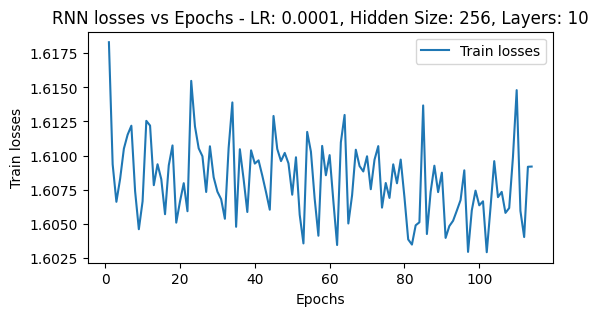

Training RNN with LR: 1e-05, Hidden Size: 64, Layers: 2
Convergence reached at epoch 37
train Accuracy: 0.2135
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]


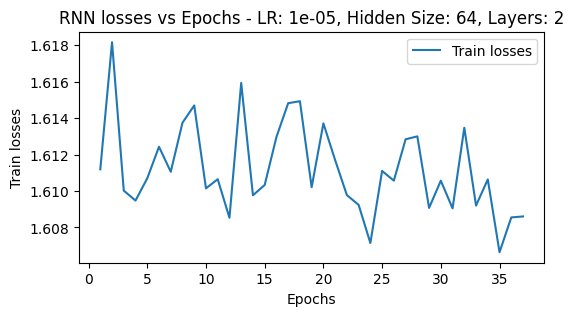

Training RNN with LR: 1e-05, Hidden Size: 64, Layers: 5
Convergence reached at epoch 29
train Accuracy: 0.2079
Test Accuracy: 0.1461
[[ 0  0  0 24  0]
 [ 0  0  0 15  0]
 [ 0  0  0 14  0]
 [ 0  0  0 13  0]
 [ 0  0  0 23  0]]


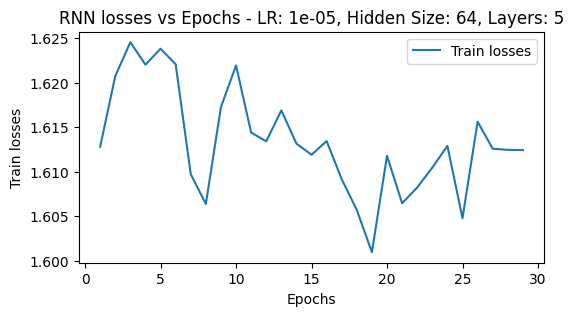

Training RNN with LR: 1e-05, Hidden Size: 64, Layers: 10
Convergence reached at epoch 13
train Accuracy: 0.2079
Test Accuracy: 0.1461
[[ 0  0  0 24  0]
 [ 0  0  0 15  0]
 [ 0  0  0 14  0]
 [ 0  0  0 13  0]
 [ 0  0  0 23  0]]


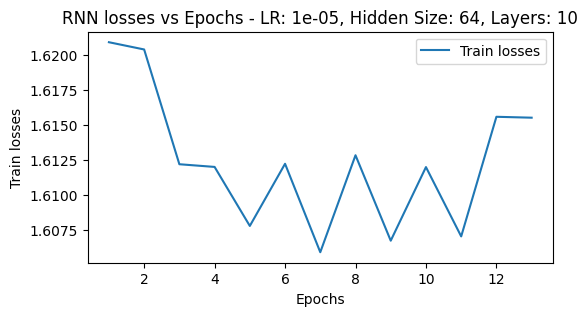

Training RNN with LR: 1e-05, Hidden Size: 128, Layers: 2
Convergence reached at epoch 42
train Accuracy: 0.2135
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]


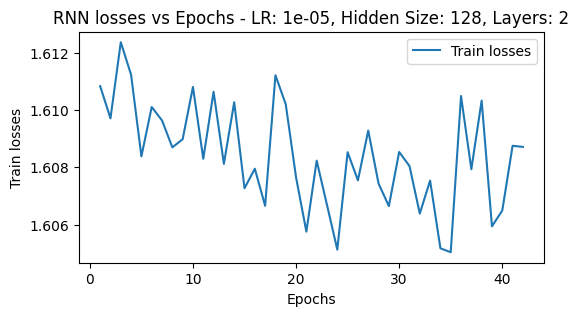

Training RNN with LR: 1e-05, Hidden Size: 128, Layers: 5
Convergence reached at epoch 12
train Accuracy: 0.2135
Test Accuracy: 0.1573
[[ 0  0 24  0  0]
 [ 0  0 15  0  0]
 [ 0  0 14  0  0]
 [ 0  0 13  0  0]
 [ 0  0 23  0  0]]


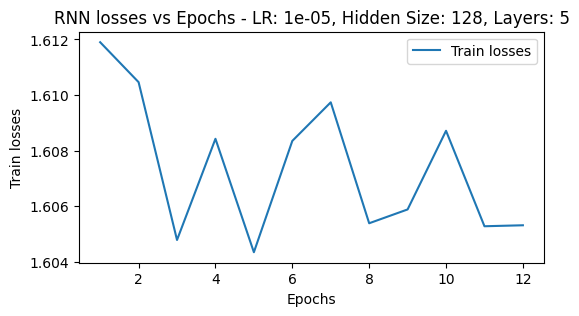

Training RNN with LR: 1e-05, Hidden Size: 128, Layers: 10
Convergence reached at epoch 39
train Accuracy: 0.2107
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]


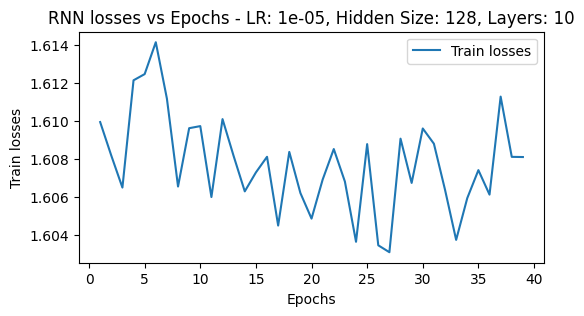

Training RNN with LR: 1e-05, Hidden Size: 256, Layers: 2
Convergence reached at epoch 5
train Accuracy: 0.2079
Test Accuracy: 0.1461
[[ 0  0  0 24  0]
 [ 0  0  0 15  0]
 [ 0  0  0 14  0]
 [ 0  0  0 13  0]
 [ 0  0  0 23  0]]


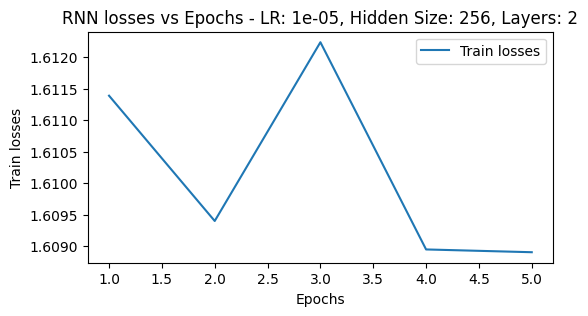

Training RNN with LR: 1e-05, Hidden Size: 256, Layers: 5
Convergence reached at epoch 7
train Accuracy: 0.2107
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]


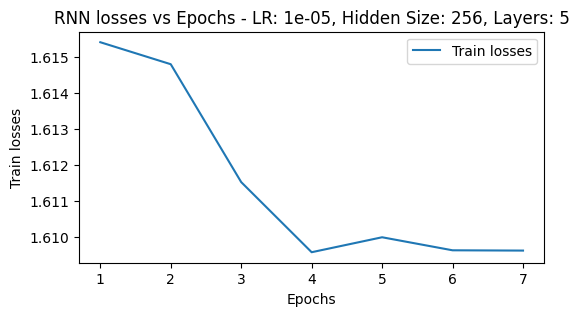

Training RNN with LR: 1e-05, Hidden Size: 256, Layers: 10
Convergence reached at epoch 78
train Accuracy: 0.2079
Test Accuracy: 0.1461
[[ 0  0  0 24  0]
 [ 0  0  0 15  0]
 [ 0  0  0 14  0]
 [ 0  0  0 13  0]
 [ 0  0  0 23  0]]


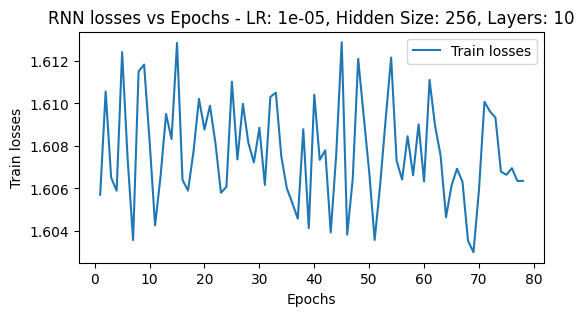

In [64]:
# Loop over all hyperparameter combinations for RNN
for lr in learning_rates:
    for hidden_size in hidden_sizes:
        for num_layers in num_layers_list:

            print(f"Training RNN with LR: {lr}, Hidden Size: {hidden_size}, Layers: {num_layers}")

            #Definig the criterion:
            criterion = nn.CrossEntropyLoss()

            # RNN Model Definition
            rnn_model = RNNModel(input_size, hidden_size, num_layers, num_classes).to(device)
            rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)

            # Train and evaluate the RNN model
            rnn_train_accuracy, rnn_test_accuracy, rnn_train_losses = train_and_evaluate_model(
                rnn_model, train_loader, test_loader, criterion, rnn_optimizer, num_epochs=1000, device=device
            )

            # Store results
            results.append({
                'model_type': 'RNN',
                'lr': lr,
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'train_accuracy': rnn_train_accuracy,
                'test_accuracy': rnn_test_accuracy
            })

            # Plot accuracy vs. epochs for RNN
            plot_losses_vs_epochs(rnn_train_losses, 'RNN', [lr, hidden_size, num_layers])

            # Update the best RNN model
            if rnn_test_accuracy > best_rnn_accuracy:
                best_rnn_accuracy = rnn_test_accuracy
                best_rnn_model = rnn_model

In [65]:
# Train and test confusion matrix for the best RNN model
print("Evaluating the best RNN model:")
best_train_acc_rnn , best_test_acc_rnn , _ = train_and_evaluate_model(best_rnn_model, train_loader, test_loader, criterion, rnn_optimizer, num_epochs=1000, device=device)
print(f"Best RNN model had {best_train_acc_rnn:.4f} train accuracy.")
print(f"Best RNN model had {best_test_acc_rnn:.4f} test accuracy.")
print(f"Best RNN model had {best_rnn_model.hidden_size} hidden size of layers.")
print(f"Best RNN model had {best_rnn_model.num_layers} number of hidden layers.")
print(f"Best RNN model had {0.0001} learning rate.")

print('\n')
# Train and test confusion matrix for the best LSTM model
print("Evaluating the best LSTM model:")
best_train_acc_lstm , best_test_acc_lstm , _ = train_and_evaluate_model(best_lstm_model, train_loader, test_loader, criterion, lstm_optimizer, num_epochs=1000, device=device)
print(f"Best LSTM model had {best_train_acc_lstm:.4f} train accuracy.")
print(f"Best LSTM model had {best_test_acc_lstm:.4f} test accuracy.")
print(f"Best LSTM model had {best_lstm_model.hidden_size} hidden size of layers.")
print(f"Best LSTM model had {best_lstm_model.num_layers} number of hidden layers.")
print(f"Best LSTM model had {0.001} learning rate.")


Evaluating the best RNN model:
Convergence reached at epoch 36
train Accuracy: 0.2135
Test Accuracy: 0.1685
[[ 0 24  0  0  0]
 [ 0 15  0  0  0]
 [ 0 14  0  0  0]
 [ 0 13  0  0  0]
 [ 0 23  0  0  0]]
Best RNN model had 0.2135 train accuracy.
Best RNN model had 0.1685 test accuracy.
Best RNN model had 64 hidden size of layers.
Best RNN model had 2 number of hidden layers.
Best RNN model had 0.0001 learning rate.


Evaluating the best LSTM model:
Convergence reached at epoch 14
train Accuracy: 0.1854
Test Accuracy: 0.2584
[[ 0  0  0  0 24]
 [ 0  0  0  0 15]
 [ 0  0  0  0 14]
 [ 0  0  0  0 13]
 [ 0  0  0  0 23]]
Best LSTM model had 0.1854 train accuracy.
Best LSTM model had 0.2584 test accuracy.
Best LSTM model had 64 hidden size of layers.
Best LSTM model had 2 number of hidden layers.
Best LSTM model had 0.001 learning rate.


In [66]:
#Conclusion:
import pandas as pd
Dict_con = pd.DataFrame(results)
Dict_con

,model_type,lr,hidden_size,num_layers,train_accuracy,test_accuracy
0,LSTM,0.00100,64,2,0.202247,0.168539
1,LSTM,0.00100,64,5,0.213483,0.157303
2,LSTM,0.00100,64,10,0.213483,0.157303
3,LSTM,0.00100,128,2,0.210674,0.168539
4,LSTM,0.00100,128,5,0.210674,0.168539
5,LSTM,0.00100,128,10,0.213483,0.157303
6,LSTM,0.00100,256,2,0.210674,0.146067
7,LSTM,0.00100,256,5,0.213483,0.157303
8,LSTM,0.00100,256,10,0.213483,0.157303
9,LSTM,0.00010,64,2,0.185393,0.258427
